In [1]:
# Bad subjects
# Bad IDs: 605515760919, 601983541597

# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split3.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

467
155
{'meta': {'AgeInMonths': 110, 'Gender': 'M', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 1, 'AgeGroupEdge1': 103, 'AgeGroupEdge2': 144}, 'rest': '765', 'nback': '790', 'emoid': '554', 'ID': 608665596582}


In [2]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [3]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [4]:
# Create labels (ages)

y_train = np.vstack([subj['meta']['AgeInMonths'] for subj in train])
y_test = np.vstack([subj['meta']['AgeInMonths'] for subj in test])

print('Complete')

Complete


In [5]:
# Torch

import torch
import torch.nn as nn
import torch.nn.functional as F

cuda = torch.device('cuda')

train_rest_ts_torch = [torch.from_numpy(subj.T).float().cuda() for subj in train_rest_ts]
test_rest_ts_torch = [torch.from_numpy(subj.T).float().cuda() for subj in test_rest_ts]

# print(train_rest_ts_torch[0].device)
print(train_rest_ts_torch[0].shape)
print('Complete')

torch.Size([210, 264])
Complete


In [6]:
import torch

torch.cuda.empty_cache()

t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0) 
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print('Total: {:f} Reserved: {:f} Allocated: {:f} Free: {:f}'.format(t,r,a,f))

Total: 4294967296.000000 Reserved: 146800640.000000 Allocated: 138213376.000000 Free: 8587264.000000


In [9]:
nt = train_rest_ts_torch[0].shape[0]
nroi = train_rest_ts_torch[0].shape[1]
nBatch = 5
nB = nBatch*nt
nHid = 100
nLat = 80

from scipy.stats import norm
import matplotlib.pyplot as plt

def makeGaussPointsDet(nB, nLat):
    Y = np.linspace(0.0001,0.9999,nB)
    x = norm.ppf(Y)
#     y = norm.pdf(x)
#     plt.plot(x,y)
#     plt.show()
    xLat = x.reshape([-1,1])@np.ones([1,nLat])
    return torch.from_numpy(xLat).float().cuda()
    
xLatPrior = makeGaussPointsDet(nB, nLat)
# xTLatPrior = makeGaussPointsDet(nLat, nB).T

def calcOptLoss(xLat, xLatPrior):
    idcs = torch.argsort(xLat,0)
    loss = torch.sum((xLatPrior-torch.gather(xLat,0,idcs))**2)
    return loss
#     return torch.sum(torch.zeros(1).cuda())

# Try to force ROIs to be well clustered at a certain time point
def calcClusterLoss(xLat):
    m = torch.mean(xLat, 1, True)
    loss = torch.sum((xLat - m)**2)
    return loss
#     return torch.sum(torch.zeros(1).cuda())

class AEOT(nn.Module):
    def __init__(self):
        super(AEOT, self).__init__()
        self.en1 = nn.Linear(nroi,nHid).cuda()
        self.en2 = nn.Linear(nHid,nLat).cuda()
        self.de1 = nn.Linear(nLat,nHid).cuda()
        self.de2 = nn.Linear(nHid,nroi).cuda()
        
    def forward(self, x):
        x = F.relu(self.en1(x))
        z = self.en2(x)
        x = F.relu(self.de1(z))
        x = self.de2(x)
        return x, z
    
aeot = AEOT()
optim = torch.optim.Adam(aeot.parameters(), lr=1e-3)

print('Complete')

Complete


In [13]:
import random

N = len(train_rest_ts_torch)
runningTot = 0
runningOpt = 0
runningCluster = 0
nEpoch = 5000
pPeriod = 200

for epoch in range(nEpoch):
    batch = []
    for i in range(nBatch):
        idx = random.randint(0,N-1)
        subj = train_rest_ts_torch[idx]
        batch.append(subj)
    batch = torch.cat(batch)
    optim.zero_grad()
    recon, z = aeot(batch)
    reconLoss = torch.sum((recon-batch)**2)
    optLoss = calcOptLoss(z, xLatPrior)
    clusterLoss = calcClusterLoss(z)
    loss = reconLoss + optLoss + clusterLoss
    runningCluster += clusterLoss.cpu()
    runningOpt += optLoss.cpu()
    runningTot += loss.cpu()
    loss.backward()
    optim.step()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            runningCluster = runningCluster/pPeriod
            runningOpt = runningOpt/pPeriod
            runningTot = runningTot/pPeriod
        print('epoch {:d} clusterLoss={:f} optLoss={:f} loss={:f}'.format(epoch, clusterLoss, runningOpt, runningTot))
        runningCluster = 0
        runningOpt = 0
        runningTot = 0

print('Finished training')

epoch 0 clusterLoss=1386.041870 optLoss=711.922974 loss=93346.226562
epoch 200 clusterLoss=1273.525513 optLoss=428.888672 loss=87191.757812
epoch 400 clusterLoss=1174.469482 optLoss=448.349792 loss=87515.281250
epoch 600 clusterLoss=1206.920654 optLoss=407.556030 loss=89326.562500
epoch 800 clusterLoss=1110.476685 optLoss=423.523163 loss=87517.398438
epoch 1000 clusterLoss=1156.416138 optLoss=396.770966 loss=87559.257812
epoch 1200 clusterLoss=1154.601074 optLoss=402.486603 loss=86566.882812
epoch 1400 clusterLoss=1154.328857 optLoss=413.100586 loss=87843.031250
epoch 1600 clusterLoss=1127.086426 optLoss=382.989532 loss=87252.750000
epoch 1800 clusterLoss=1075.645996 optLoss=426.464935 loss=86975.140625
epoch 2000 clusterLoss=1128.501953 optLoss=419.049713 loss=87246.109375


KeyboardInterrupt: 

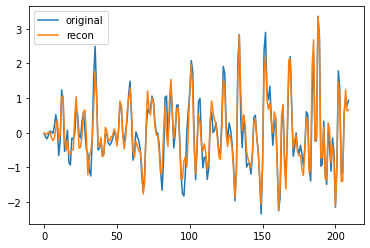

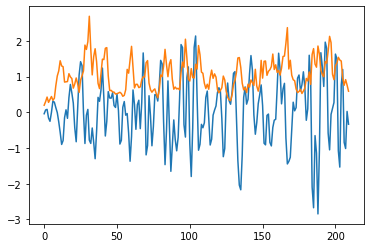

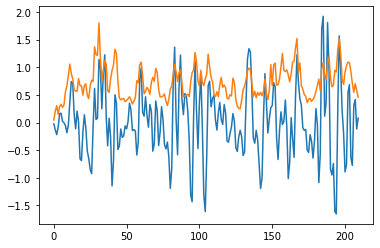

In [75]:
import matplotlib.pyplot as plt

x0 = train_rest_ts_torch[67]
x1, z = aeot(x0)

x0 = x0.cpu().detach().numpy()
x1 = x1.cpu().detach().numpy()
z = z.cpu().detach().numpy()

plt.plot(x0[:,0], label='original')
plt.plot(x1[:,0], label='recon')
plt.legend()
plt.show()

mz = z.mean(axis=1)
sz = z.std(axis=1)
plt.plot(mz, label='mean state')
plt.plot(10*sz, label='std of state')
plt.show()

mx0 = x0.mean(axis=1)
sx0 = x0.std(axis=1)
plt.plot(mx0, label='mean of original signal')
plt.plot(sx0, label='std of original signal')
plt.show()

In [76]:
print(train[67])

{'meta': {'AgeInMonths': 184, 'Gender': 'F', 'Ethnicity': 'OTHER/MIXED', 'AgeGroupID': 3, 'AgeGroupEdge1': 180, 'AgeGroupEdge2': 216}, 'rest': '634', 'nback': '651', 'emoid': '414', 'ID': 607263095972}


In [77]:
import math

nt = train_rest_ts_torch[0].shape[0]
nroi = 80#train_rest_ts_torch[0].shape[1]
nBatch = 10
nc = 8
sz1 = math.floor((nt-4-5)/2+1)
# sz2 = math.floor((nt-6-5)/2+1)
sz3 = math.floor((nt-8-5)/2+1)
sz11 = math.floor((sz1-4))
# sz22 = math.floor((sz2-4))
sz33 = math.floor((sz3-4))
# D = nc*C
D = nc*(sz11+sz33)

class ClusterCNN(nn.Module):
    def __init__(self):
        super(ClusterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1,nc,(5,nroi)).cuda() # Output size (nt-4)x1
#         self.conv2 = nn.Conv2d(1,nc,(7,nroi)).cuda() # Output size (nt-6)x1
        self.conv3 = nn.Conv2d(1,nc,(9,nroi)).cuda() # Output size (nt-8)x1
        self.mp1 = nn.MaxPool2d((5,1),(2,1)) # Output size (A-10)/5+1)x1 
        self.conv4 = nn.Conv2d(nc,nc,(5,1)).cuda() # Output size (B-4)x1
#         self.fc1 = nn.Linear(nc*(sz1+sz2+sz3),30).cuda()
        self.fc1 = nn.Linear(D,100).cuda()
        self.fc2 = nn.Linear(100,1).cuda()
        
    def forward(self, x):
        nb = x.shape[0]
        x = x.detach().unsqueeze(1)
        a = self.mp1(F.relu(self.conv1(x)))
#         b = self.mp1(F.relu(self.conv2(x)))
        c = self.mp1(F.relu(self.conv3(x)))
        a = F.relu(self.conv4(a))
#         b = F.relu(self.conv4(b))
        c = F.relu(self.conv4(c))
        x = torch.cat((a,c),dim=2)
        x = x.reshape([nb,D])
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
#         xmean = torch.mean(x,dim=3,keepdim=True)
#         xstd = torch.std(x,dim=3,keepdim=True)
#         x = torch.cat((xmean,xstd),dim=3)
#         a = self.mp1(F.relu(self.conv1(x)))
#         b = self.mp1(F.relu(self.conv2(x)))
#         c = self.mp1(F.relu(self.conv3(x)))
#         x = torch.cat((a,b,c),dim=2)
#         x = x.reshape(nb,nc*(sz1+sz2+sz3))
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x
        
clustercnn = ClusterCNN()
optimcnn = torch.optim.Adam(clustercnn.parameters(), lr=1e-3)

print('Complete')

Complete


In [78]:
train_rest_z_torch = []
test_rest_z_torch = []

for subj in train_rest_ts_torch:
    x,z = aeot(subj)
    train_rest_z_torch.append(z)
    
for subj in test_rest_ts_torch:
    x,z = aeot(subj)
    test_rest_z_torch.append(z)
    
print('Complete')

Complete


In [80]:
# Train CNN

import random

N = len(train_rest_z_torch)
running = 0
nEpoch = 2000
pPeriod = 200

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nBatch).cuda()
    for i in range(nBatch):
        idx = random.randint(0,N-1)
        subj = train_rest_z_torch[idx]
        batch.append(subj)
        truth[i] = y_train[idx,0]
    batch = torch.stack(batch,dim=0)
    optimcnn.zero_grad()
    pred = clustercnn(batch).flatten()
    loss = torch.sum((truth-pred)**2)
    loss.backward()
    running += loss.cpu()
    optimcnn.step()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            running /= pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, running))
        running = 0

print('Finished training')

epoch 0 loss=1290.047729
epoch 200 loss=974.036865
epoch 400 loss=526.194397
epoch 600 loss=312.203430
epoch 800 loss=211.360138
epoch 1000 loss=131.341309
epoch 1200 loss=80.111496
epoch 1400 loss=118.132919


KeyboardInterrupt: 

In [75]:
x = torch.rand(2,2).cuda()
A = torch.rand(1,2,requires_grad=True).cuda()
B = torch.rand(2,2).cuda()
x = torch.mean(x,dim=1,keepdim=True)
res = A@x
loss = torch.sum((B-res)**2)
loss.backward()


In [45]:
print(train_rest_ts[0].T.shape)

# Calculate the Pearson correlation coefficient
# Assumes normalized to mean=0 and std=1
def pearsonr(ts):
    nt = ts.shape[0]
    return ts.T@ts/nt

(231, 264)


In [129]:
# Before VAEOT, raw Pearson

Xtrain = np.zeros([len(train_rest_ts), 264*264])
Xtest = np.zeros([len(test_rest_ts), 264*264])

for i in range(len(train_rest_ts)):
    Xtrain[i,:] = pearsonr(train_rest_ts[i].T).flatten()
    
for i in range(len(test_rest_ts)):
    Xtest[i,:] = pearsonr(test_rest_ts[i].T).flatten()
    
print(train_rest_ts[0].T.shape)
print('Complete')

(210, 264)
Complete


In [81]:
yTrain = y_train.flatten()
yTest = y_test.flatten()

w, r, _, _ = np.linalg.lstsq(Xtrain, yTrain, rcond=None)

print('Complete')

NameError: name 'Xtrain' is not defined

In [87]:
# Get the mean std values

train_rest_mean_torch = [subj.mean(axis=1) for subj in train_rest_ts_torch]
test_rest_mean_torch = [subj.mean(axis=1) for subj in test_rest_ts_torch]

train_rest_std_torch = [subj.std(axis=1) for subj in train_rest_ts_torch]
test_rest_std_torch = [subj.std(axis=1) for subj in test_rest_ts_torch]

train_rest_z_mean_torch = [subj.mean(axis=1) for subj in train_rest_z_torch]
test_rest_z_mean_torch = [subj.mean(axis=1) for subj in test_rest_z_torch]

train_rest_z_std_torch = [subj.std(axis=1) for subj in train_rest_z_torch]
test_rest_z_std_torch = [subj.std(axis=1) for subj in test_rest_z_torch]

print(train_rest_mean_torch[0].shape)

torch.Size([210])


In [98]:
# Mean/std CNN
import math

nt = train_rest_ts_torch[0].shape[0]
nc = 8
sz1 = math.floor((nt-4-5)/2+1)
sz3 = math.floor((nt-8-5)/2+1)
sz11 = math.floor((sz1-4))
sz33 = math.floor((sz3-4))
D = nc*(sz11+sz33)

class MSCNN(nn.Module):
    def __init__(self):
        super(MSCNN, self).__init__()
#         self.conv1 = nn.Conv2d(1,nc,(5,2)).cuda() # Output size (nt-4)x1
        self.conv3 = nn.Conv2d(1,nc,(9,2)).cuda() # Output size (nt-8)x1
        self.mp1 = nn.MaxPool2d((5,1),(2,1)) # Output size (A-10)/5+1)x1 
        self.conv4 = nn.Conv2d(nc,nc,(5,1)).cuda() # Output size (B-4)x1
        self.fc1 = nn.Linear(nc*sz33,100).cuda()
        self.fc2 = nn.Linear(100,1).cuda()
        
    def forward(self, x):
        nb = x.shape[0]
        x = x.detach().unsqueeze(1)
#         a = self.mp1(F.relu(self.conv1(x)))
        c = self.mp1(F.relu(self.conv3(x)))
#         a = F.relu(self.conv4(a))
        c = F.relu(self.conv4(c))
        x = c
#         x = torch.cat((a,c),dim=2)
        x = x.reshape([nb,nc*sz33])
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
mscnn = MSCNN()
optimcnn = torch.optim.Adam(mscnn.parameters(), lr=1e-3)

print('Complete')

Complete


In [101]:
# Train MSCNN

import random

N = len(train_rest_z_torch)
running = 0
nEpoch = 5000
pPeriod = 200

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nBatch).cuda()
    for i in range(nBatch):
        idx = random.randint(0,N-1)
        m = train_rest_mean_torch[idx]
        s = train_rest_std_torch[idx]
        batch.append(torch.stack((m,s),dim=1))
        truth[i] = y_train[idx,0]
    batch = torch.stack(batch,dim=0)
    optimcnn.zero_grad()
    pred = mscnn(batch).flatten()
    loss = torch.sum((truth-pred)**2)
    loss.backward()
    running += loss.cpu()
    optimcnn.step()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            running /= pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, running))
        running = 0

print('Finished training')

epoch 0 loss=6214.696289
epoch 200 loss=7557.924805
epoch 400 loss=7361.901367
epoch 600 loss=7351.056152
epoch 800 loss=7181.254395
epoch 1000 loss=6909.368164
epoch 1200 loss=6532.916016
epoch 1400 loss=7416.068848
epoch 1600 loss=6841.278320
epoch 1800 loss=6034.137695
epoch 2000 loss=6254.762695
epoch 2200 loss=5682.923340
epoch 2400 loss=5951.629395
epoch 2600 loss=5397.390137
epoch 2800 loss=5200.432617
epoch 3000 loss=5175.756836
epoch 3200 loss=4681.125488
epoch 3400 loss=5035.186035
epoch 3600 loss=4497.009766
epoch 3800 loss=4854.995117
epoch 4000 loss=4142.198730
epoch 4200 loss=4176.301758
epoch 4400 loss=3965.737549
epoch 4600 loss=4023.631836
epoch 4800 loss=3568.723633
epoch 4999 loss=3480.418457
Finished training


[[1.         0.42494781]
 [0.42494781 1.        ]]
3.512689519749122
2.883914545530914


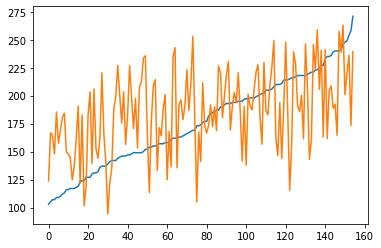

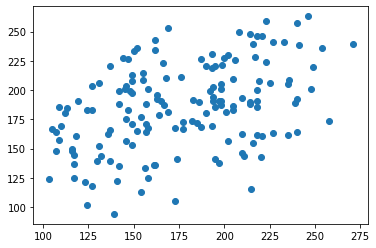

In [102]:
import matplotlib.pyplot as plt

y = y_test.flatten()
X = []

# for subj in train_rest_z_torch:
#     X.append(subj)
for idx in range(len(test_rest_mean_torch)):
    m = test_rest_mean_torch[idx]
    s = test_rest_std_torch[idx]
    X.append(torch.stack((m,s),dim=1))
    
X = torch.stack(X, dim=0)
yPred = mscnn(X).flatten().cpu().detach().numpy()

# yPred = Xtest@w

idcs = np.argsort(y)
yPred = yPred[idcs]
y = y[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()